This is only a draft for experimentations. The final report is in `Solution.ipynb`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

Define constants and training parameters:

In [4]:
DATASET_PATH = './data'

BATCH_SIZE = 1024
SHUFFLE_TRAIN = True

NUM_EPOCHS = 100

## Task 1

Train and compare the following models on the CIFAR-10 dataset (available in PyTorch). The models should have slightly optimized parameters to try to maximize their performance.

### Load dataset

In [30]:
train_dataset = datasets.CIFAR10(root=DATASET_PATH, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root=DATASET_PATH, train=False, transform=transforms.ToTensor(), download=True)

CLASSES = train_dataset.classes

In [6]:
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

eval_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        # drop_last=True
    )

### MLP

In [7]:
LR = 1e-3

INPUT_DIM = np.prod(train_dataset.data.shape[-3:]) # 32*32*3
OUTPUT_DIM = len(set(train_dataset.targets)) # 10

hidden_dim = int((INPUT_DIM + OUTPUT_DIM) * 2/3) # 2/3 rule
print(f"input dim={INPUT_DIM}, output dim={OUTPUT_DIM}, hidden={hidden_dim}")

input dim=3072, output dim=10, hidden=2054


In [8]:
from models import MLP

mlp = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM)
mlp = mlp.to(device)

In [10]:
from train import train

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=LR)

losses = train(mlp, NUM_EPOCHS, train_loader, eval_loader, device, criterion, optimizer)

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 100 Iteration 49: loss 0.00138. : 100%|██████████| 49/49 [00:04<00:00, 12.10it/s]


In [ ]:
from save_utils import save_model_config

save_model_config(mlp, 'std_mlp_3-layers')

saved to models/std_mlp_4-layers_06-36_22-04-2025.pth


## Task 2 Analysis

  - Compare the performance of both models: investigate their learning curves (train/eval loss), compare their test accuracy, and compute their confusion matrix
  - Visualize some images, along with the predictions from your models. In what images do your models fail more often? Why do you think so?

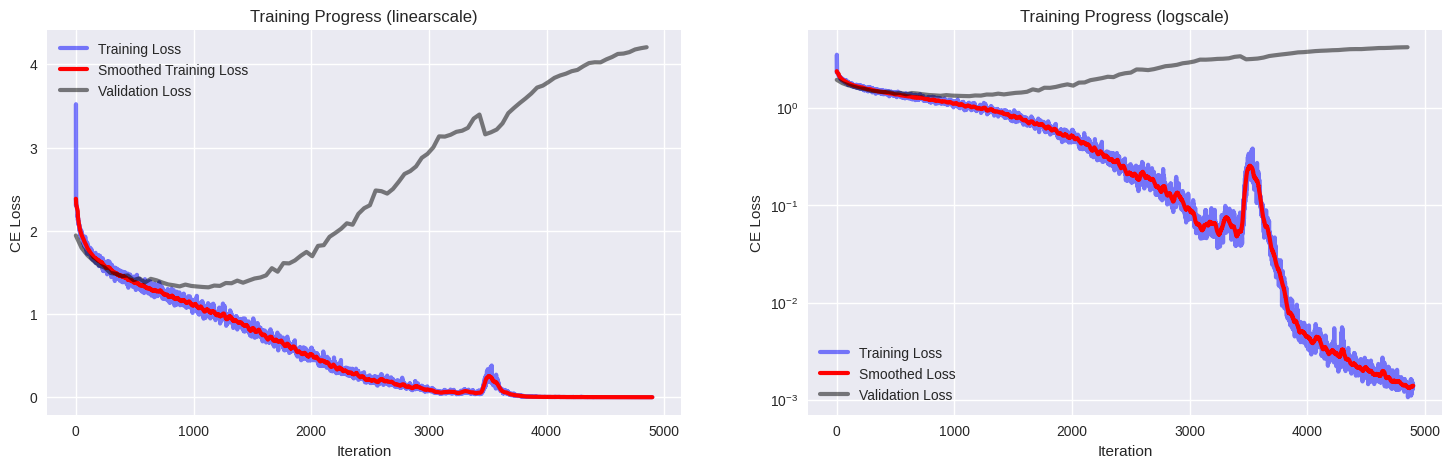

In [12]:
from visualize import plot_learning_curve

plot_learning_curve(losses[0], losses[1], len(losses[0])//len(losses[1]))

In [13]:
from evaluate import evaluate
from torchmetrics.classification import MulticlassConfusionMatrix

confmat = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics = evaluate(mlp, eval_loader, device, confmat)

print(metrics)

100%|██████████| 10/10 [00:00<00:00, 11.43it/s]

{'accuracy': 54.559999999999995, 'confusion_matrix': MulticlassConfusionMatrix()}


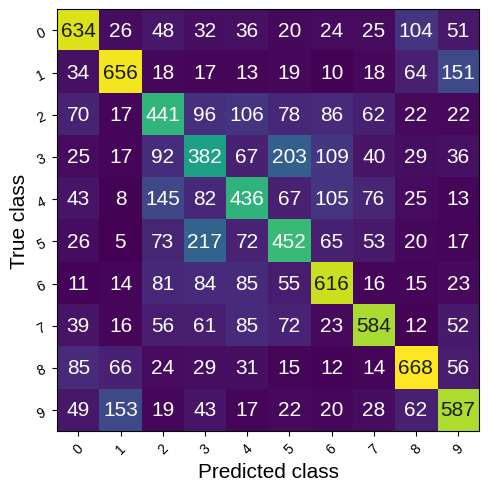

In [17]:
fig_, ax_ = metrics['confusion_matrix'].plot()

463 missclassified images in the first test batch
all class labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


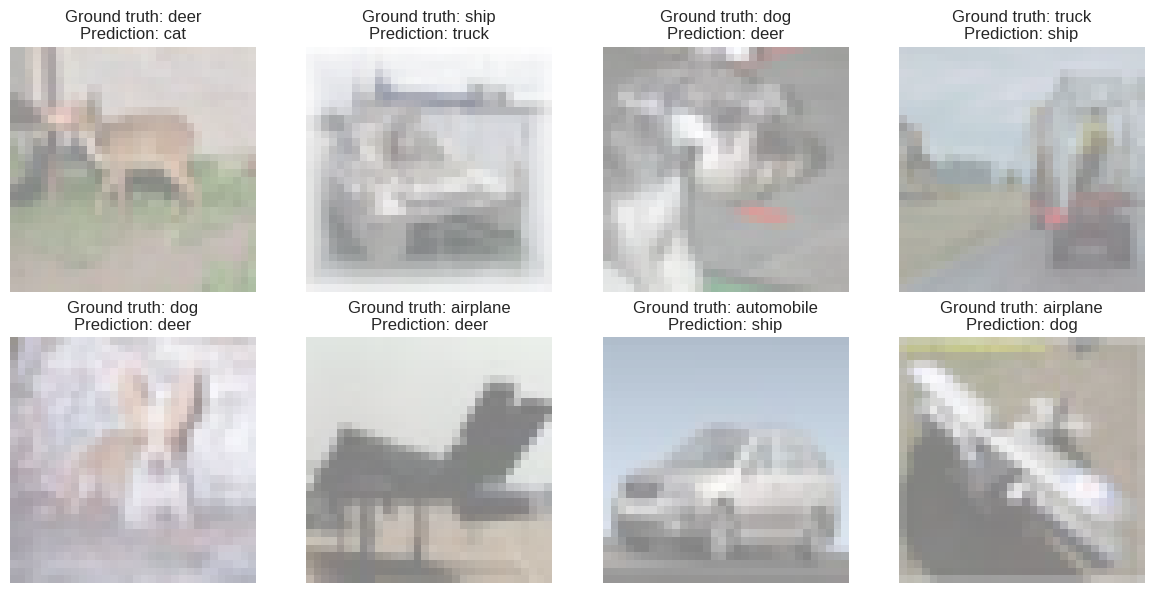

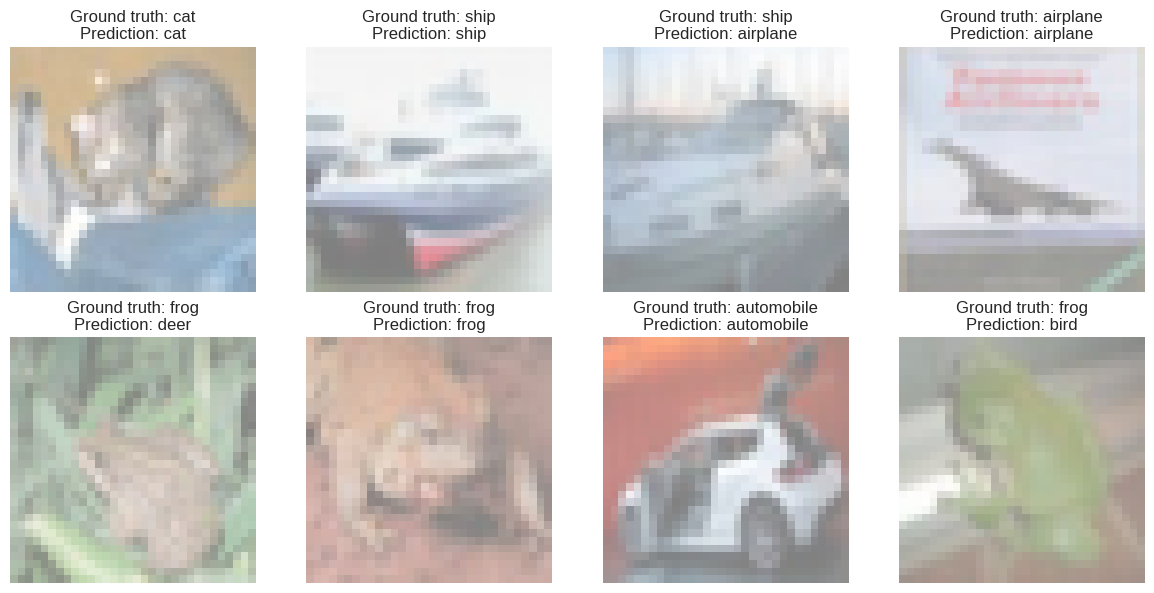

In [ ]:
from visualize import plot_images

first_batch = next(iter(eval_loader))
images, targets = first_batch
targets = targets.cpu()
predictions = mlp(images.to(device)).argmax(dim=1).cpu()
images = images.cpu()
print("all available class labels:", CLASSES)

# take failed samples from the batch
diff_indices = np.where(targets != predictions)[0]
print(f"{len(diff_indices)} missclassified images in the first test batch")
sample_ids = diff_indices[len(diff_indices)//2:]

plot_images(images[sample_ids], targets[sample_ids].cpu(), predictions[sample_ids].cpu(), CLASSES)
plot_images(images, targets.cpu(), predictions.cpu(), CLASSES)

## Task 3 Mitigate Overfitting

  - Train both models with and without DropOut. Compare the results: training and validation loss, accuracy, ...
  - Implement and use **your own** custom learning rate warmup and learning rate scheduler criterion to avoid overfitting.<br>
    It is not allowed to use PyTorch's schedulers, but you should code your own.<br>
    Train **one model** using it and show whether you can mitigate overfitting.

### With dropout training

In [19]:
mlp_with_dropout = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM, use_dropout=True)
mlp_with_dropout = mlp_with_dropout.to(device)

mlp_with_dropout_criterion = nn.CrossEntropyLoss()
mlp_with_dropout_optimizer = torch.optim.Adam(mlp_with_dropout.parameters(), lr=LR)

mlp_with_dropout_losses = train(mlp_with_dropout, NUM_EPOCHS, train_loader, eval_loader,
                                device, mlp_with_dropout_criterion, mlp_with_dropout_optimizer)

Epoch 100 Iteration 49: loss 0.97720. : 100%|██████████| 49/49 [00:04<00:00, 12.10it/s]


In [20]:
confmat_with_dropout = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics_with_dropout = evaluate(mlp_with_dropout, eval_loader, device, confmat_with_dropout)

print(metrics_with_dropout)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 12.59it/s]

{'accuracy': 54.96, 'confusion_matrix': MulticlassConfusionMatrix()}


In [21]:
save_model_config(mlp, 'dropout_mlp_3-layers')

saved to models/dropout_mlp_3-layers_07-00_22-04-2025.pth


### Training with Learning Rate Scheduler

In [23]:
# define new model
mlp_with_scheduler = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM, use_dropout=True)
mlp_with_scheduler = mlp_with_scheduler.to(device)

# criterion, optimizer
mlp_with_scheduler_criterion = nn.CrossEntropyLoss()
mlp_with_scheduler_optimizer = torch.optim.Adam(mlp_with_scheduler.parameters(), lr=LR)

Define Scheduler

In [24]:
from schedulers import cosine_decay, LearningRateScheduler

WARMUP_EPOCHS = 5

# apply cosine rate decay after warmup phase
decay_func=lambda e: cosine_decay(e, epochs=(NUM_EPOCHS - WARMUP_EPOCHS))
lr_scheduler_mlp = LearningRateScheduler(LR, mlp_with_scheduler_optimizer, decay_func, WARMUP_EPOCHS)

Train MLP with a scheduler

In [26]:
# train the model
mlp_with_scheduler_losses = train(mlp_with_scheduler, NUM_EPOCHS, train_loader, eval_loader, device,
                                  mlp_with_scheduler_criterion, mlp_with_scheduler_optimizer, lr_scheduler_mlp)

# evaluation
confmat_with_scheduler = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics_with_scheduler = evaluate(mlp_with_scheduler, eval_loader, device, confmat_with_scheduler)
print(metrics_with_scheduler)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 11.92it/s]

{'accuracy': 55.52, 'confusion_matrix': MulticlassConfusionMatrix()}


In [27]:
save_model_config(mlp, 'scheduled_mlp_3-layers')

saved to models/scheduled_mlp_3-layers_07-15_22-04-2025.pth
